In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cv2
import seaborn as sns
import rasterio.features
import rasterio.transform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from utils import get_dataset, prepare_data, process_single_fire, scale_numerical_data, expand_array_elements

In [2]:
df = get_dataset("../data/dataset.csv")

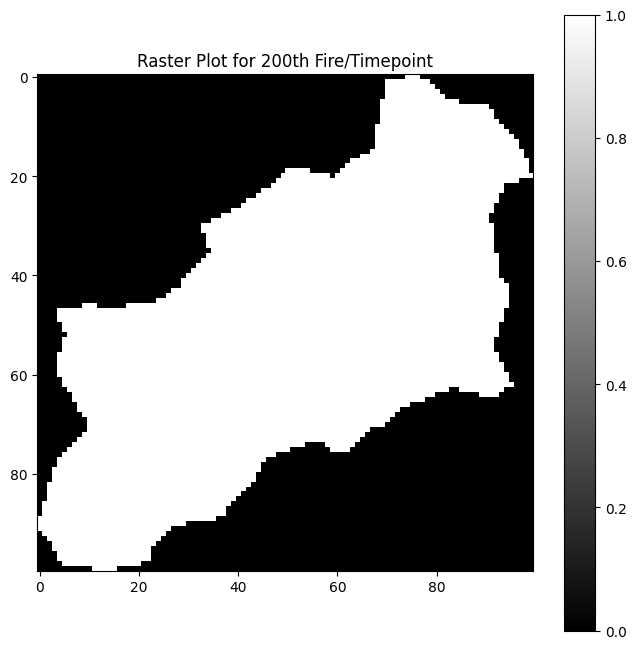

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(df.raster[200], cmap='gray')
plt.colorbar()
plt.title('Raster Plot for 200th Fire/Timepoint')
plt.show()

In [4]:
s = df[df.FIRE_NAME == "FLAT"]
X, y = process_single_fire(s)
print(X)
print(y)

[[array([0, 0, 0, ..., 0, 0, 0]), np.float64(54.0), np.float64(1.08), np.float64(0.95), np.float64(6.5), np.float64(7.770000000000001e-08), np.float64(250.99), np.float64(0.027), np.float64(0.29)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(59.0), np.float64(1.15), np.float64(0.94), np.float64(7.2), np.float64(8.030000000000001e-08), np.float64(250.97), np.float64(0.0258), np.float64(0.36)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(60.0), np.float64(1.14), np.float64(0.9200000000000002), np.float64(5.990000000000001), np.float64(7.500000000000001e-08), np.float64(250.85), np.float64(0.0254), np.float64(0.36)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(66.0), np.float64(1.25), np.float64(0.91), np.float64(6.48), np.float64(7.920000000000002e-08), np.float64(250.89), np.float64(0.0253), np.float64(0.45)], [array([0, 0, 0, ..., 0, 0, 0]), np.float64(57.0), np.float64(1.0), np.float64(0.9), np.float64(6.260000000000001), np.float64(6.260000000000003e-08), np.float64(250.55), np.float

In [5]:
X, y = prepare_data(df)
X_scaled = np.array(expand_array_elements(scale_numerical_data(X)))
y = np.array(y)

In [6]:
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [7]:
print(X_scaled.shape)
print(y.shape)

(5427, 1, 10008)
(5427, 10000)


In [ ]:
df.FIRE_NAME.unique

In [8]:
len(df.FIRE_NAME.unique())

421

In [10]:
df.groupby("FIRE_NAME").size()

FIRE_NAME
1-12  BUTTE LIGHTNING COMPLEX     2
1-7  BUTTE LIGHTNING COMPLEX      4
1-8  BUTTE LIGHTNING COMPLEX      3
ABERNATHY                         2
ABNEY                            54
                                 ..
WOOLSEY                           6
WRAGG                             3
WYE                               2
YORK                             19
ZOGG                              6
Length: 421, dtype: int64

In [16]:
df.head(8)

,Unnamed: 0,YYYYMMDD,geometry,FIRE_NAME,latitude,longitude,burning_index,evapotranspiration_al,fuel_moisture_1000,relative_humidity_max,specific_humidity,temperature_max,vpd,wind_speed,raster,raster_flat
0,0,2012-07-12,POLYGON ((-123.33477800000003 40.7968479999999...,FLAT,40.790442,-123.335819,54.0,1.08,0.95,6.50,7.770000e-08,250.99,0.0270,0.29,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2012-07-13,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792111,-123.336071,59.0,1.15,0.94,7.20,8.030000e-08,250.97,0.0258,0.36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2012-07-14,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792633,-123.334991,60.0,1.14,0.92,5.99,7.500000e-08,250.85,0.0254,0.36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,2012-07-15,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792755,-123.332730,66.0,1.25,0.91,6.48,7.920000e-08,250.89,0.0253,0.45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,2012-07-16,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792319,-123.331770,57.0,1.00,0.90,6.26,6.260000e-08,250.55,0.0212,0.32,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,5,2012-07-29,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792081,-123.331662,54.0,0.99,0.90,5.81,6.290000e-08,250.83,0.0258,0.27,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,6,2012-08-27,"POLYGON ((-123.339584 40.79840099999996, -123....",FLAT,40.792271,-123.333336,70.0,0.90,0.65,9.23,6.130000e-08,250.29,0.0163,0.41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,7,2018-08-16,POLYGON ((-121.01109299999997 41.4194979999999...,STONE,41.407860,-121.033639,65.0,0.87,0.64,6.05,6.070000e-08,250.35,0.0204,0.31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [23]:
sets = [int(x) - 1 for x in list(df.FIRE_NAME.value_counts().reindex(df.FIRE_NAME.drop_duplicates()).values)]

In [ ]:
# LSTM model Arch
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(100*100))  # Output the flattened raster (10000) - need to convert back to 2D later

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

c:\Users\Nathan\anaconda3\envs\ecs171project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
def training_model_batches(sets, X_scaled, y, model, epochs=50):
    model_history = []
    start_index, end_index = 0, 0
    for batch in sets:
        start_index = end_index
        end_index += batch
        dataX = X_scaled[start_index:end_index]
        dataY = y[start_index:end_index]
        info = model.fit(dataX, dataY, epochs=epochs, batch_size=1)
        model_history.append(info)
    return model, model_history

In [ ]:
trained, histories = training_model_batches(sets, X_scaled, y, model, epochs=50)
trained.save('model_v1.h5')

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4229
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1447
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1054
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0880
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1152
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1503
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0952
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0737
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0802
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0858
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0955
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0748
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0581
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0438
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0418
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━

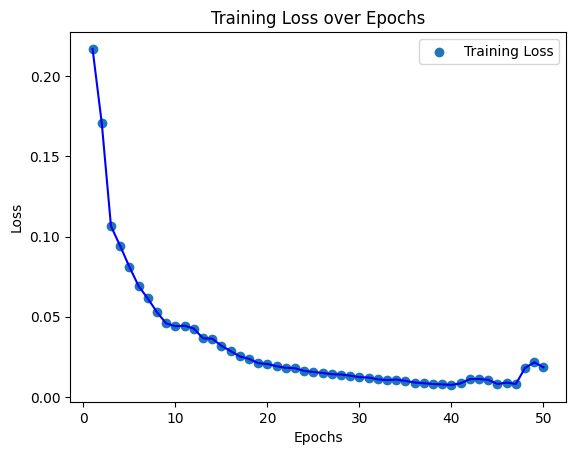

In [48]:
epochs = range(1, len(histories[1].history['loss']) + 1)
loss = histories[4].history['loss']

plt.scatter(epochs, loss, label='Training Loss')
plt.plot(epochs, loss, color='blue')

plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [63]:
prediction = trained.predict(X_scaled[40].reshape(1, X_scaled.shape[1], X_scaled.shape[2]))
prediction = prediction.reshape((100, 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


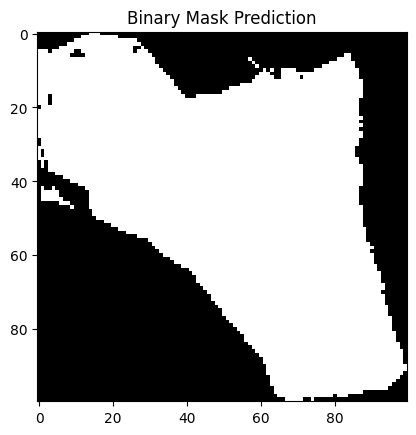

In [64]:
binary_mask = (prediction > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask Prediction')
plt.show()

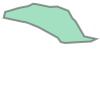

In [56]:
df.geometry[50]